In [1]:
## Import needed libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import requests
import json
import matplotlib.dates as mdates


In [2]:
##Importing data from 2017-01 to 2019-07
##Printing head and tail
df = pd.read_csv('C:\Sth\study\AOTPall_12Routes.csv', low_memory=False)

In [3]:
##Select the route: DCA to BOS and needed feature
df = df[(df['Origin']=='DCA') & (df['Dest']=='BOS')][['FlightDate','DepDelay']]

In [4]:
##transfer Datetime column to datetime format
df.FlightDate = pd.to_datetime(df.FlightDate, format='%Y-%m-%d')
train = df

In [5]:
#group flight data by index
train.index = train.FlightDate
train = train.resample('D').mean()

In [6]:
#pick the last two months data
train_test = train.tail(61)

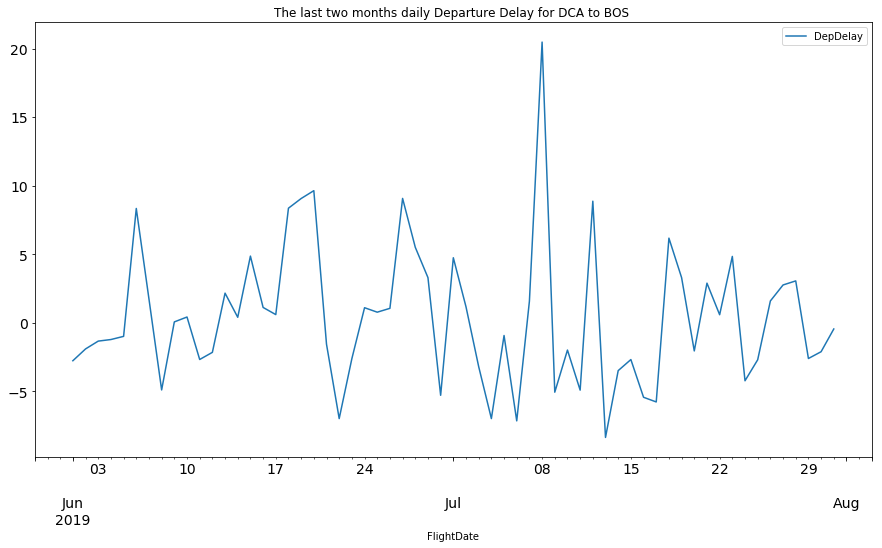

In [7]:
#View the time series data
train_test.plot(figsize=(15,8), title= 'The last two months daily Departure Delay for DCA to BOS ', fontsize=14)

In [8]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(train_test['DepDelay'])

Results of Dickey-Fuller Test:
Test Statistic                -7.003622e+00
p-value                        7.215477e-10
#Lags Used                     0.000000e+00
Number of Observations Used    6.000000e+01
Critical Value (1%)           -3.544369e+00
Critical Value (5%)           -2.911073e+00
Critical Value (10%)          -2.593190e+00
dtype: float64


In [9]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
#apply kpss test on the series
kpss_test(train_test['DepDelay'])

Results of KPSS Test:
Test Statistic            0.166203
p-value                   0.100000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


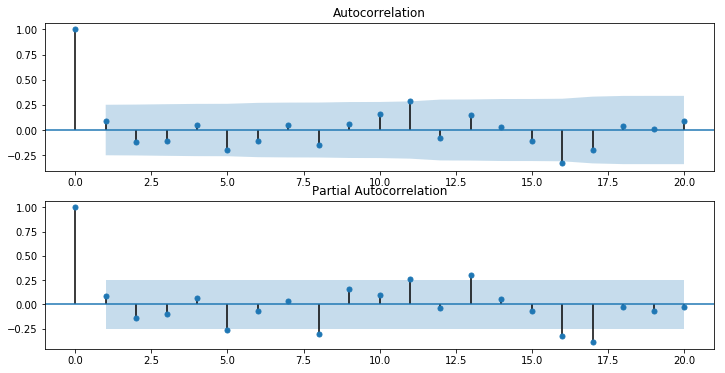

In [10]:
#Autocorreletion
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(train_test.DepDelay.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(train_test.DepDelay.dropna(), ax=ax[1], lags=20)

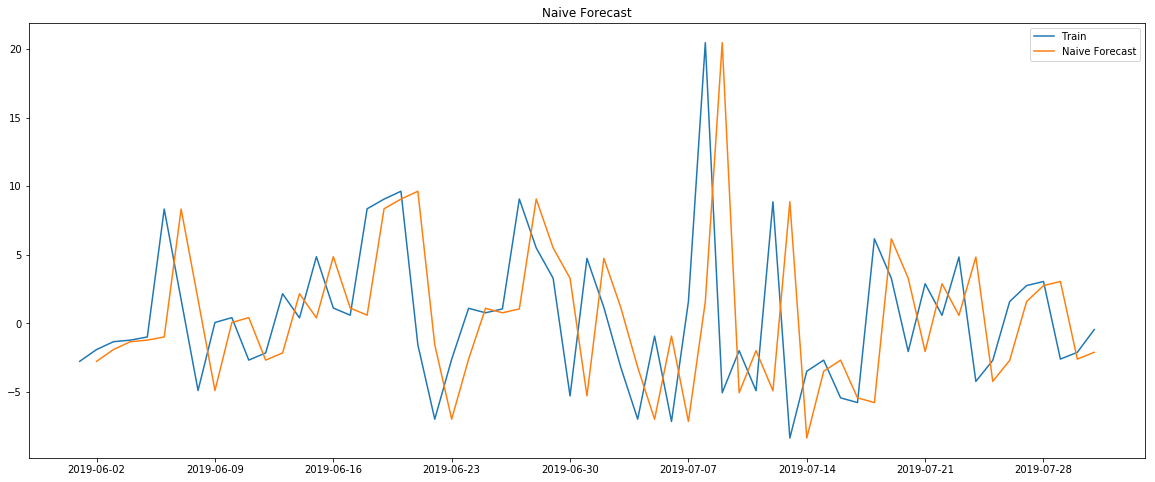

In [11]:
#Naive Forecast Method 
dd = np.asarray(train_test.DepDelay)
y_hat = train_test.copy()
y_hat['naive'] = train_test['DepDelay'].shift(1)
plt.figure(figsize=(20,8))
plt.plot(train_test.index, train_test['DepDelay'], label='Train')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [12]:
#Caculate the Naive Forecast accuracy by rmse
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(train_test.DepDelay[1:], y_hat.naive[1:]))
print(rms)

6.9341622197286865


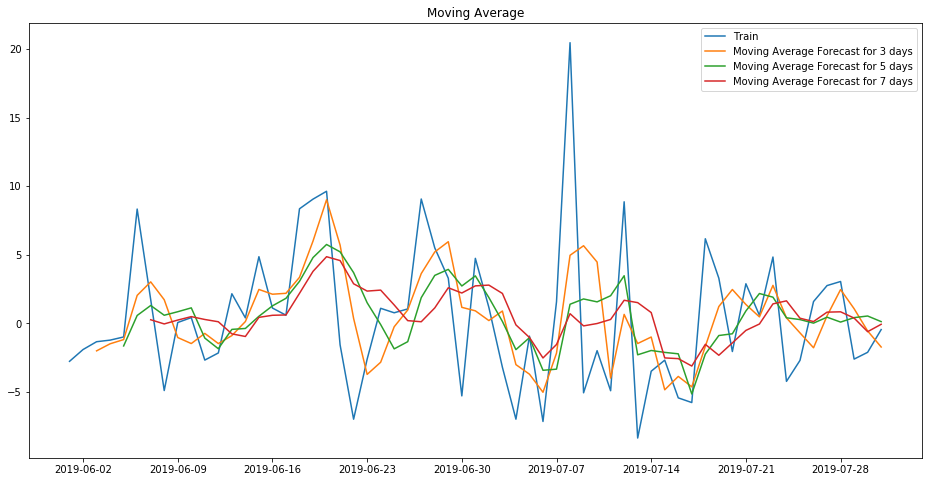

In [13]:
#Moving Average Method
y_hat_avg = train_test.copy()
y_hat_avg['moving_avg_3_forecast'] = train_test['DepDelay'].rolling(3).mean()
y_hat_avg['moving_avg_5_forecast'] = train_test['DepDelay'].rolling(5).mean()
y_hat_avg['moving_avg_7_forecast'] = train_test['DepDelay'].rolling(7).mean()

plt.figure(figsize=(16,8))
plt.plot(train_test['DepDelay'], label='Train')
plt.plot(y_hat_avg['moving_avg_3_forecast'], label='Moving Average Forecast for 3 days')
plt.plot(y_hat_avg['moving_avg_5_forecast'], label='Moving Average Forecast for 5 days')
plt.plot(y_hat_avg['moving_avg_7_forecast'], label='Moving Average Forecast for 7 days')
plt.legend(loc='best')
plt.title("Moving Average")
plt.show()

In [14]:
##Caculate the Moving Average Forecast accuracy by rmse
rms3 = sqrt(mean_squared_error(train_test.DepDelay[3:], y_hat_avg.moving_avg_3_forecast[3:]))
rms5 = sqrt(mean_squared_error(train_test.DepDelay[5:], y_hat_avg.moving_avg_5_forecast[5:]))
rms7 = sqrt(mean_squared_error(train_test.DepDelay[7:], y_hat_avg.moving_avg_7_forecast[7:]))
print(rms3)
print(rms5)
print(rms7)

4.368155568327104
4.804342839303879
5.091798688286101


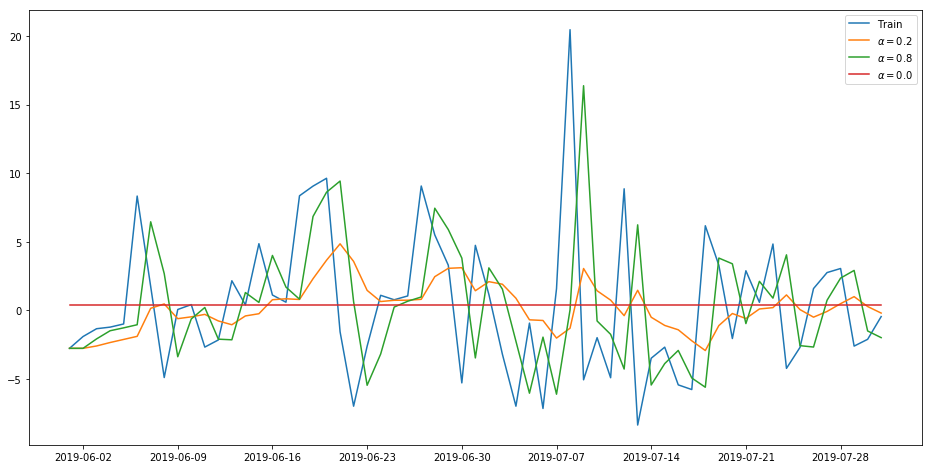

In [15]:
#Exponential Smoothing Method
y_hat_avg = train_test.copy()
fit1 = SimpleExpSmoothing(np.asarray(train_test['DepDelay'])).fit(smoothing_level=0.2, optimized=False)
fit2 = SimpleExpSmoothing(np.asarray(train_test['DepDelay'])).fit(smoothing_level=0.8, optimized=False)
fit3 = SimpleExpSmoothing(np.asarray(train_test['DepDelay'])).fit(optimized=True)
y_hat_avg['SES1'] = fit1.fittedvalues
y_hat_avg['SES2'] = fit2.fittedvalues
y_hat_avg['SES3'] = fit3.fittedvalues
plt.figure(figsize=(16,8))
plt.plot(train_test['DepDelay'], label='Train')
plt.plot(y_hat_avg['SES1'], label=r'$\alpha=0.2$')
plt.plot(y_hat_avg['SES2'], label=r'$\alpha=0.8$')
plt.plot(y_hat_avg['SES3'], label=r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
plt.legend(loc='best')
plt.show()

In [16]:
##Caculate the Moving Average Forecast accuracy by rmse
rms1 = sqrt(mean_squared_error(train_test.DepDelay, y_hat_avg.SES1))
rms2 = sqrt(mean_squared_error(train_test.DepDelay, y_hat_avg.SES2))
rms3 = sqrt(mean_squared_error(train_test.DepDelay, y_hat_avg.SES3))
print(rms1)
print(rms2)
print(rms3)

5.460400354993614
6.414412220623215
5.097705336041301
